 #  <p style="text-align: center;">Technical Support Data Analysis

Technical support data can often be a rich source of information on opportunities for improving customer experience. The lesser the trouble customers have with the product the better. Even better when the customers are able to overcome
technical challenge quickly with minimal effort. Let us analyze the tech support data and do some basic analysis on problem types, time to resolve the problem and channel of suppor that is most suitable

## Loading the Dataset

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection  import train_test_split
from sklearn.cluster import KMeans
#import sklearn.metrics

tech_supp_df = pd.read_csv("technical_support_data.csv")
tech_supp_df.dtypes

PROBLEM_TYPE              object
no_of_cases                int64
Avg_pending_calls        float64
Avg_resol_time             int64
recurrence_freq          float64
Replace_percent          float64
In_warranty_percent        int64
Post_warranty_percent      int64
dtype: object

The dataset contains one record for each unique problem type. It has metrics for each type like count, average calls to resolve, average resolution time etc.

In [2]:
tech_supp_df.head()

,PROBLEM_TYPE,no_of_cases,Avg_pending_calls,Avg_resol_time,recurrence_freq,Replace_percent,In_warranty_percent,Post_warranty_percent
0,Temperature control not working,170,1.3,32,0.04,0.0,75,25
1,power chord does not tightly fit,12,2.0,150,0.01,0.5,5,95
2,Fan swing not working,5,1.0,35,0.02,0.2,90,10
3,Main switch does not on,3,2.0,8,0.01,0.7,5,95
4,Forgot mobile app password,45,2.3,54,0.15,0.0,99,1


In [3]:
from scipy.stats import zscore

numeric_cols = tech_supp_df.drop('PROBLEM_TYPE', axis=1)

Prob_type  = tech_supp_df.pop("PROBLEM_TYPE")

numeric_cols = numeric_cols.apply(zscore)

tech_supp_df = numeric_cols.join(Prob_type)   # Recreating mpg_df by combining numerical columns with car names

tech_supp_df.head()

,no_of_cases,Avg_pending_calls,Avg_resol_time,recurrence_freq,Replace_percent,In_warranty_percent,Post_warranty_percent,PROBLEM_TYPE
0,0.179429,-0.701207,-0.538351,-0.843188,-0.561463,0.138067,-0.138067,Temperature control not working
1,-0.862176,0.027143,1.510857,-1.101765,2.245854,-1.778204,1.778204,power chord does not tightly fit
2,-0.908323,-1.013357,-0.486253,-1.015573,0.561463,0.548696,-0.548696,Fan swing not working
3,-0.921508,0.027143,-0.955140,-1.101765,3.368781,-1.778204,1.778204,Main switch does not on
4,-0.644625,0.339294,-0.156296,0.104930,-0.561463,0.795074,-0.795074,Forgot mobile app password


## Group Data into similar clusters

Now, we will use K-Means clustering to group data based on their attribute. First, we need to determine the optimal number of groups. For that we conduct the knee test to see where the knee happens.

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

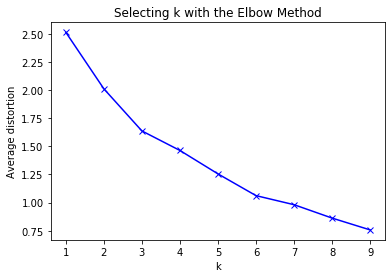

In [4]:
tech_supp_attributes = tech_supp_df.drop("PROBLEM_TYPE",axis=1)

#Finding optimal no. of clusters
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(tech_supp_attributes)
    prediction=model.predict(tech_supp_attributes)
    meanDistortions.append(sum(np.min(cdist(tech_supp_attributes, model.cluster_centers_, 'euclidean'), axis=1)) / tech_supp_attributes.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')


Though the bend is not coming out clearly as there are many bends, let us look at 2 clusters and 3 clusters

In [5]:
# Let us first start with K = 2
final_model=KMeans(2)
final_model.fit(tech_supp_attributes)
prediction=final_model.predict(tech_supp_attributes)

#Append the prediction 
tech_supp_df["GROUP"] = prediction
print("Groups Assigned : \n")
tech_supp_df[["PROBLEM_TYPE", "GROUP"]]

Groups Assigned : 



,PROBLEM_TYPE,GROUP
0,Temperature control not working,1
1,power chord does not tightly fit,1
2,Fan swing not working,1
3,Main switch does not on,1
4,Forgot mobile app password,0
5,AC stops abruptly,0
6,App hangs while entring commands,0
7,App takes a long time to initialize,1
8,Unable to connect the App to the device,1
9,Reinstalling the app hangs the phone,0


In [7]:
final_model.cluster_centers_

array([[-0.7105498 ,  1.23115099,  1.20818948, -0.10439466, -0.44114987,
         0.79898435, -0.79898435],
       [ 0.31086554, -0.53862856, -0.5285829 ,  0.04567266,  0.19300307,
        -0.34955565,  0.34955565]])

Analyze the distribution of the data among the two groups (K = 2). One of the most informative visual tool is boxplot.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E776608D08>,
      dtype=object)

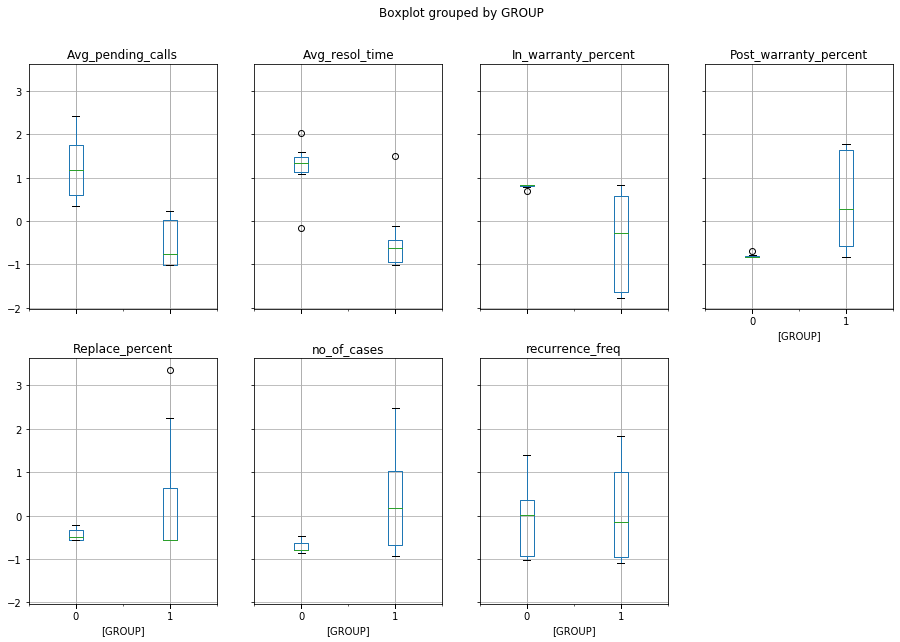

In [6]:
#plt.cla()

#plt.boxplot([[tech_supp_df["no_of_cases"][tech_supp_df.GROUP==0]],
 #            [tech_supp_df["no_of_cases"][tech_supp_df.GROUP==1]] ],
     #         labels=('GROUP 1','GROUP 2'))

tech_supp_df.boxplot(by = 'GROUP',  layout=(2,4), figsize=(15, 10))


In [17]:
# The K = 2 boxplot clearly shows outliers in group 1. Indicating that the group 1 is stretched
# indicating probability of another cluster. Let us try with K = 3, the next elbow point

In [8]:
# Let us first start with K = 3
final_model=KMeans(10)
final_model.fit(tech_supp_attributes)
prediction=final_model.predict(tech_supp_attributes)

#Append the prediction 
tech_supp_df["GROUP"] = prediction
print("Groups Assigned : \n")
tech_supp_df[["PROBLEM_TYPE", "GROUP"]]

Groups Assigned : 



,PROBLEM_TYPE,GROUP
0,Temperature control not working,3
1,power chord does not tightly fit,4
2,Fan swing not working,3
3,Main switch does not on,7
4,Forgot mobile app password,3
5,AC stops abruptly,6
6,App hangs while entring commands,0
7,App takes a long time to initialize,3
8,Unable to connect the App to the device,1
9,Reinstalling the app hangs the phone,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E778136D48>,
      dtype=object)

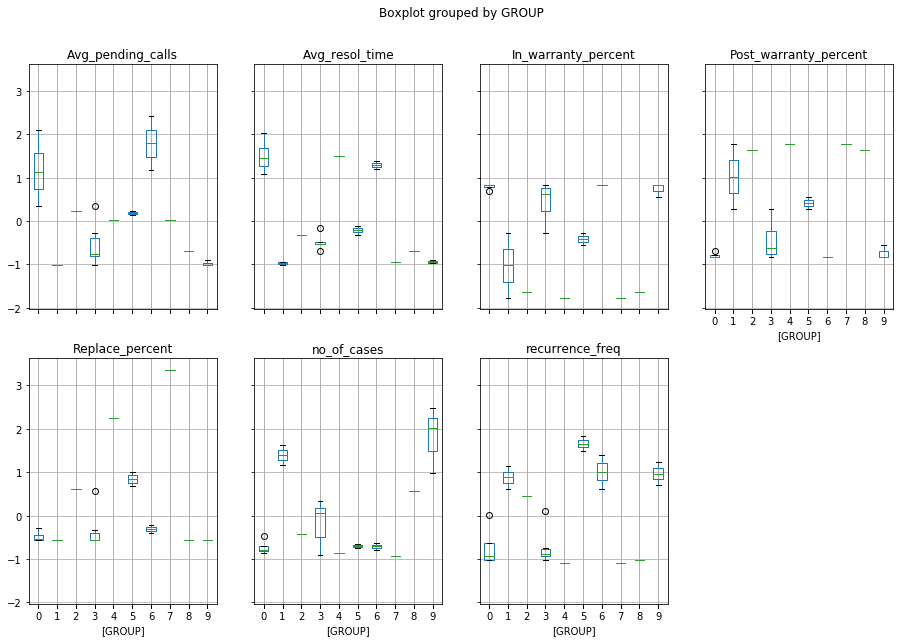

In [9]:
#plt.cla()

#plt.cla()

#plt.boxplot([[tech_supp_df["no_of_cases"][tech_supp_df.GROUP==0]],
 #            [tech_supp_df["no_of_cases"][tech_supp_df.GROUP==1]] ],
     #         labels=('GROUP 1','GROUP 2'))

tech_supp_df.boxplot(by = 'GROUP',  layout=(2,4), figsize=(15, 10))



In [11]:
# Number of cases in Group 0 is high but resolution time is very low and pending calls too is low.... (teething problem)
# Number of cases in group 1 is second highest, pending calls is also second highest, resolution time is slightly higher
# Replacement_percent is very high.... (Design problem)

# What does this indicate?